In [332]:
# Обучение классификатора картинок на примере CIFAR-100 (датасет можно изменить) сверточной сетью (самописной)
# Обучение классификатора картинок на примере CIFAR-100 (датасет можно изменить) через дообучение ImageNet Resnet-50
# Обучение классификатора картинок на примере CIFAR-100 (датасет можно изменить) через дообучение ImageNet Resnet-50
# с аугментацией (самописной, с использованием Pytorch встроенных методов)

In [333]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torchvision
from torchvision import transforms
from torch import nn
from sklearn.model_selection import train_test_split


In [334]:
train = torchvision.datasets.CIFAR100(root='Lecture04',
                                  train=True,
                                  download=True)

Files already downloaded and verified


In [335]:
class MyCifar(torch.utils.data.Dataset):
    
    def __init__(self, cifar, transformation=None):
        self.cifar = cifar
        self.transformation = transformation
    
    def __len__(self):
        return len(self.cifar)
        
    def __getitem__(self, index):
        image = self.cifar[index][0]
        if self.transformation is not None:
            image = self.transformation(image)
        return image, self.cifar[index][1]     
        

In [336]:
target_list = train.classes

In [337]:
def show_cifar(batch, num, if_tensor=False):
    plt.figure(figsize=(10, 10))
    for i in range(num):
        ax = plt.subplot(np.sqrt(num), np.sqrt(num), i + 1)
        if if_tensor:
            plt.imshow(batch[i][0].permute(1, 2, 0))
        else:
            plt.imshow(batch[i][0])
        ax.set_title(target_list[batch[i][1]])

/var/folders/lw/sfx9kxt17jj8cb5s59ll44q80000gp/T/ipykernel_23629/3860036165.py:4: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot(np.sqrt(num), np.sqrt(num), i + 1)


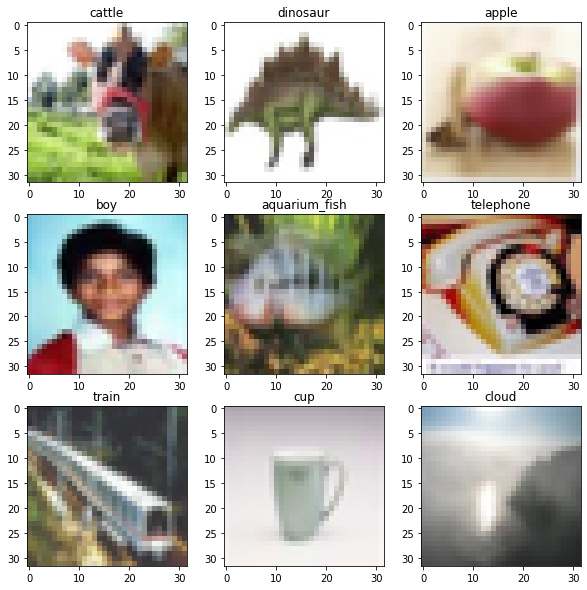

In [338]:
show_cifar(train, 9)

In [339]:
X_train, X_test = train_test_split(train, test_size=0.23, random_state=42)

In [340]:
augmentation = torchvision.transforms.Compose([
    #transforms.ColorJitter(brightness=0.2, hue=0.2, contrast=0.1),
    transforms.RandomCrop(32),
    transforms.RandomHorizontalFlip(p=0.35),
    transforms.RandomRotation(degrees=(45, 45)),
    transforms.GaussianBlur(3),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    
])
simple_transform = torchvision.transforms.Compose([transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ])

In [341]:
base_train = MyCifar(X_train,  transformation=simple_transform)
base_train_aug = MyCifar(X_train, transformation=augmentation)
base_test = MyCifar(X_test, transformation=transforms.ToTensor())

In [342]:
base_train[0]

(tensor([[[-0.4397,  0.7419,  1.2385,  ...,  0.1426,  0.2967,  0.4508],
          [ 0.5022,  0.8789,  1.1700,  ...,  0.8789,  0.8447,  0.9646],
          [ 0.7591,  0.9646,  1.0844,  ...,  0.8276,  0.8276,  0.9132],
          ...,
          [-0.8849, -0.8164, -0.8678,  ...,  0.9646,  0.8961,  0.8961],
          [-0.7308, -0.9020, -0.9363,  ...,  0.8789,  0.9303,  0.9132],
          [-0.6794, -0.8164, -0.9020,  ...,  0.9646,  1.0159,  0.9988]],
 
         [[-0.2500,  0.9230,  1.3957,  ...,  0.1352,  0.3102,  0.4678],
          [ 0.6954,  1.0630,  1.3606,  ...,  0.8179,  0.7829,  0.8880],
          [ 0.9755,  1.1681,  1.2731,  ...,  0.8529,  0.8529,  0.8704],
          ...,
          [-0.4076, -0.2675, -0.3550,  ...,  0.7829,  0.6954,  0.6604],
          [-0.3375, -0.4426, -0.3901,  ...,  0.7129,  0.7654,  0.6954],
          [-0.3025, -0.4251, -0.4951,  ...,  0.8004,  0.8529,  0.7829]],
 
         [[-0.2184,  1.0888,  1.6814,  ...,  0.1999,  0.2696,  0.4265],
          [ 0.8622,  1.2631,

In [343]:
train_loader = torch.utils.data.DataLoader(base_train,
                                          batch_size=128, 
                                          shuffle=True,
                                          num_workers=2,
                                          drop_last=True)
train_aug_loader = torch.utils.data.DataLoader(base_train_aug,
                                          batch_size=128, 
                                          shuffle=True,
                                          num_workers=2,
                                          drop_last=True)
test_loader = torch.utils.data.DataLoader(base_test,
                                         batch_size=128,
                                         shuffle=False,
                                         drop_last=True)

In [344]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.bn1 = nn.BatchNorm2d(3)
        self.conv1 = nn.Conv2d(3, 30, 3)
        self.bn2 = nn.BatchNorm2d(30)
        self.conv2 = nn.Conv2d(30, 60, 3)
        self.bn3 = nn.BatchNorm2d(60)
        self.conv3 = nn.Conv2d(60, 120, 3)
        self.bn4 = nn.BatchNorm2d(120)
        self.dr = nn.Dropout(0.25)
        self.l1 = nn.Linear(800, 400)
        self.l2 = nn.Linear(400, 200)
        self.l3 = nn.Linear(200, 100)

    def forvard(self, x):
        
        x = self.bn1(x)
        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = nn.MaxPool2d(2)(x)
        
        x = self.bn2(x)
        x = self.conv2(x)
        x = nn.ReLU()(x)
        x = nn.Maxpool2d(2)(x)
        
        x = self.bn3(x)
        x = self.conv3(x)
        x = nn.ReLU()(x)
        x = nn.Maxpool2d(2)(x)
        
        x = self.bn4(x)
        x = x.view(x.size(0), -1)
        x = self.dr(x)
        x = self.l1(x)
        x = nn.ReLU()(x)
        x = self.l2(x)
        x = nn.ReLU()(x)
        x = self.l3(x)
        
        return x
          
    
    

In [345]:
network = Network()
print(network)

Network(
  (bn1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(3, 30, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(30, 60, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(60, 120, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dr): Dropout(p=0.25, inplace=False)
  (l1): Linear(in_features=800, out_features=400, bias=True)
  (l2): Linear(in_features=400, out_features=200, bias=True)
  (l3): Linear(in_features=200, out_features=100, bias=True)
)


In [346]:
len(train_loader)

300

In [347]:
optimizer = torch.optim.Adam(network.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [348]:
def training(train_loader, epochs):
    network.train()
    total_loss = []
    for epoch in tqdm(range(epochs)):
        epoch_loss = []
        running_loss = 0
        for ind, batch in enumerate(train_loader, 0):
            inputs, labels = batch[0], batch[1]
            print(batch[0])
            optimizer.zero_grad()
            preds = network(train_loader)
            loss = criterion(inputs, preds)
            loss.backward()
            optimizer.step()
            # статистика
            running_loss += loss.items()
            if ind % 300 == 0:
                epoch_loss.append(running_loss/(ind +1))
                print(f'[{i + 1}, {ind + 1}] loss: {running_loss / (ind +1):.3f}')
        total_loss.extend(epoch_loss)       
    return total_loss
    


In [ ]:
# Обучаемся
EPOCHS_NUM = 5
error = training(train_loader, EPOCHS_NUM)

  0%|                                                     | 0/5 [00:00<?, ?it/s]Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'MyCifar' on <module '__main__' (built-in)>
